# Data wrangling

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

## Mixing and merging data

### Relational style merges

The merge() function provides mechanisms to combine datasets conecting rows using one or more keys:

In [2]:
df1 = DataFrame( {'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                  'data1': range(7) } )
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [3]:
df2 = DataFrame( {'key': ['a', 'b', 'd'],
                  'data2': range(3) } )
df2

,key,data2
0,a,0
1,b,1
2,d,2


This is an example of a N-to-1 merge: df1 has multiple rows labeled as $a$ and $b$, while df2 has a single row for each key value. Applying merge():

In [4]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,a,2,0
3,a,4,0
4,a,5,0
5,b,6,1


Note that we did not specify which columns to use for the join. In this default case merge() uses identical column names as join keys. Another option is to explicitly give them using $on$:

In [5]:
pd.merge( df1, df2, on="key" )

,key,data1,data2
0,b,0,1
1,b,1,1
2,a,2,0
3,a,4,0
4,a,5,0
5,b,6,1


If the column names to join on are different on each object, they can be separately specified through $left\_on$ and $right\_on$:

In [6]:
df3 = DataFrame( {'key_l': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                  'data1': range(7)} )
df4 = DataFrame( {'key_r': ['a', 'b', 'd'],
                  'data2': range(3)} )
pd.merge( df3, df4, left_on='key_l', right_on='key_r' )

,key_l,data1,key_r,data2
0,b,0,b,1
1,b,1,b,1
2,a,2,a,0
3,a,4,a,0
4,a,5,a,0
5,b,6,b,1


Note how the data associated to $c$ and $d$ have disappeard after the merge. By default, merge() performs an inner join: the resulting keys are the intersection of the original key sets. This behaviour can be changed through the $how$ parameter, which accepts $"inner"$, $"left"$, $"right"$, and $"outer"$ as values:

In [7]:
pd.merge( df1, df2, how="outer" )

,key,data1,data2
0,a,2.0,0.0
1,a,4.0,0.0
2,a,5.0,0.0
3,b,0.0,1.0
4,b,1.0,1.0
5,b,6.0,1.0
6,c,3.0,NaN
7,d,NaN,2.0


N-to-N merges perform the cartesian product of the rows:

In [8]:
df1 = DataFrame( {'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                  'data1': range(6) })
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [9]:
df2 = DataFrame( {'key': ['a', 'b', 'a', 'b', 'd'],
                  'data2': range(5)} )
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [10]:
pd.merge( df1, df2, on="key", how="left" )

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


To perform the merge on multiple keys simultaneously you simply provide a sequence of them:

In [11]:
left = DataFrame( {'key1': ['aba', 'aba', 'bab'],
                   'key2': ['one', 'two', 'one'],
                   'lval': [1, 2, 3]} )
right = DataFrame( {'key1': ['aba', 'aba', 'bab', 'bab'],
                    'key2': ['one', 'one', 'one', 'two'],
                    'rval': [4, 5, 6, 7]} )
pd.merge( left, right, on=['key1', 'key2'], how="outer" )

,key1,key2,lval,rval
0,aba,one,1.0,4.0
1,aba,one,1.0,5.0
2,aba,two,2.0,NaN
3,bab,one,3.0,6.0
4,bab,two,NaN,7.0


Note that, when joining over the columns of a DataFrame, the original indices are discarded. If we want to preserve them we could manipulate the original tables using reset_index(), moving the index to a new column and preserving both in the final result.

A last question to consider is overlaps in column names. This problem can be manually solved through renaming (which we will cover later), but can also be handled using the $suffixes$ parameter to merge():

In [12]:
pd.merge( left, right, on="key1" )

,key1,key2_x,lval,key2_y,rval
0,aba,one,1,one,4
1,aba,one,1,one,5
2,aba,two,2,one,4
3,aba,two,2,one,5
4,bab,one,3,one,6
5,bab,one,3,two,7


In [13]:
pd.merge( left, right, on="key1", suffixes=('_left', '_right') )

,key1,key2_left,lval,key2_right,rval
0,aba,one,1,one,4
1,aba,one,1,one,5
2,aba,two,2,one,4
3,aba,two,2,one,5
4,bab,one,3,one,6
5,bab,one,3,two,7


### Merging over indices

When the join key is located in the indices of one or both DataFrames, we specify it using the $left\_index$ and $right\_index$ parameters:

In [14]:
left1 = DataFrame( {'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                   'data': range(6)} )
left1

,key,data
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [15]:
right1 = DataFrame( {'data': [3.5, 7]}, index=['a','b'] )
right1

,data
a,3.5
b,7.0


In [16]:
pd.merge( left1, right1, left_on="key", right_index=True )

,key,data_x,data_y
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0


In [17]:
pd.merge( left1, right1, left_on="key", right_index=True, how="outer" )

,key,data_x,data_y
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


We can also use hierarchical indices:

In [18]:
lefth = DataFrame( {'key1': ['France', 'France', 'France', 'Spain', 'Spain'],
                    'key2': [2000, 2001, 2002, 2001, 2002],
                    'data': np.arange(5)} )
lefth

,key1,key2,data
0,France,2000,0
1,France,2001,1
2,France,2002,2
3,Spain,2001,3
4,Spain,2002,4


In [19]:
righth = DataFrame( np.arange(12).reshape((6,2)),
                    index=[['Spain','Spain','France','France','France','France'],
                           [2001, 2000, 2000, 2000, 2001, 2002]],
                    columns=['event1', 'event2'] )
righth

event1  event2
Spain  2001       0       1
       2000       2       3
France 2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [20]:
pd.merge( lefth, righth, left_on=['key1','key2'], right_index=True )

,key1,key2,data,event1,event2
0,France,2000,0,4,5
0,France,2000,0,6,7
1,France,2001,1,8,9
2,France,2002,2,10,11
3,Spain,2001,3,0,1


In [21]:
pd.merge( lefth, righth, left_on=['key1','key2'], right_index=True, how="outer" )

,key1,key2,data,event1,event2
0,France,2000,0.0,4.0,5.0
0,France,2000,0.0,6.0,7.0
1,France,2001,1.0,8.0,9.0
2,France,2002,2.0,10.0,11.0
4,Spain,2000,NaN,2.0,3.0
3,Spain,2001,3.0,0.0,1.0
4,Spain,2002,4.0,NaN,NaN


We can use the index as join key on both tables:

In [22]:
left2 = DataFrame( [[1., 2.], [3., 4.], [5., 6.]],
                  index=['a', 'c', 'e'],
                  columns=['France', 'Spain'] )
left2

,France,Spain
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [23]:
right2 = DataFrame( [[7., 8.], [9., 10.], [11., 12.], [13., 14.]],
                   index = ['b', 'c', 'd', 'e'],
                   columns = ['Germany', 'Portugal'] )
right2

,Germany,Portugal
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [24]:
pd.merge( left2, right2, left_index=True, right_index=True, how="outer" )

,France,Spain,Germany,Portugal
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


The DataFrame class provides a join() method, more convenient when using indices as join key. It can be used for combining multiple DataFrame object with similar indices:

In [25]:
left2.join( right )

,France,Spain,key1,key2,rval
a,1.0,2.0,NaN,NaN,NaN
c,3.0,4.0,NaN,NaN,NaN
e,5.0,6.0,NaN,NaN,NaN


For historical reasons, DataFrame.join() uses a left join, but this behavior can be modified as with merge():

In [26]:
left2.join( right, how="outer" )

,France,Spain,key1,key2,rval
a,1.0,2.0,NaN,NaN,NaN
c,3.0,4.0,NaN,NaN,NaN
e,5.0,6.0,NaN,NaN,NaN
0,NaN,NaN,aba,one,4.0
1,NaN,NaN,aba,one,5.0
2,NaN,NaN,bab,one,6.0
3,NaN,NaN,bab,two,7.0


It does support using columns of the left operand as join key as well:

In [27]:
left1.join( right1, on="key", lsuffix="_left", rsuffix="_right" )

,key,data_left,data_right
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


Lastly, if performing simple joins over the indices we can pass a set of DataFrames to the join() method:

In [28]:
another = DataFrame( [[7., 8.], [9., 10.], [11., 12], [16., 17]],
                  index=['a', 'c', 'e', 'f'],
                  columns=['Netherlands', 'Belgium'] )
another

,Netherlands,Belgium
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [29]:
left2.join( [right2, another] )

,France,Spain,Germany,Portugal,Netherlands,Belgium
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [30]:
left2.join( [right2, another], how="outer" )

,France,Spain,Germany,Portugal,Netherlands,Belgium
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


### Concatenating over an axis

Another possible type of data combination is the concatenation or stacking. NumPy provides a concatenate() function which performs this operation with ndarray objects:

In [31]:
arr = np.arange(12).reshape((3,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [32]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

The same can be done with pandas.concat():

In [33]:
s1 = Series( [0, 1], index=['a', 'b'] )
s2 = Series( [2, 3], index=['c', 'd'] )
s3 = Series( [4, 5], index=['e', 'f'] )
pd.concat( [s1, s2, s3] )

a    0
b    1
c    2
d    3
e    4
f    5
dtype: int64

By default, concat() concatenates over the rows, generating a new Series. If we wish to concatenate columns:

In [34]:
pd.concat( [s1, s2, s3], axis=1 )

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,NaN,4.0
f,NaN,NaN,5.0


In this case there is no overlapping among the columns, and the result is the union of the indices. This aspect is also configurable:

In [35]:
s4 = pd.concat( [s1 * 5, s3] )
s4

a    0
b    5
e    4
f    5
dtype: int64

In [36]:
pd.concat( [s1, s4], axis=1 )

,0,1
a,0.0,0
b,1.0,5
e,NaN,4
f,NaN,5


In [37]:
pd.concat( [s1, s4], axis=1, join="inner" )

,0,1
a,0,0
b,1,5


A problem with this operation is that it is impossible to tell, after the join, to which of the original pieces a data belonged. A solution would be to create a hierarchical index over the concatenation axis:

In [38]:
result = pd.concat( [s1, s2, s3], keys=['one', 'two', 'three'] )
result

one    a    0
       b    1
two    c    2
       d    3
three  e    4
       f    5
dtype: int64

In [39]:
result.unstack()

,a,b,c,d,e,f
one,0.0,1.0,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,NaN,NaN
three,NaN,NaN,NaN,NaN,4.0,5.0


If the concatenation is performed over columns, the keys become column names:

In [40]:
pd.concat( [s1, s2, s3], axis=1, keys=['one', 'two', 'three'] )

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,NaN,4.0
f,NaN,NaN,5.0


The same reasoning can be applied to DataFrame objects:

In [41]:
df1 = DataFrame( np.arange(6).reshape((3,2)),
                 index=['a', 'b', 'c'],
                 columns=['one', 'two'] )
df1

,one,two
a,0,1
b,2,3
c,4,5


In [42]:
df2 = DataFrame( 5 + np.arange(4).reshape((2,2)),
                 index = ['a', 'c'],
                 columns = ['three', 'four'] )
df2

,three,four
a,5,6
c,7,8


In [43]:
pd.concat( [df1, df2], axis=1, keys=['level1', 'level2'] )

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

We can provide a dictionary instead of a list, in which case the dictionary keys will be used for the $keys$ parameter:

In [44]:
pd.concat( {'level1': df1, 'level2': df2}, axis=1 )

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

It is also possible to directly assign names to the levels generated when concatenating:

In [45]:
pd.concat( [df1, df2], axis=1, keys=['level1', 'level2'], names=['superior', 'inferior'] )

superior level1     level2     
inferior    one two  three four
a             0   1    5.0  6.0
b             2   3    NaN  NaN
c             4   5    7.0  8.0

A last consideration attaining DataFrames in which their row indices are not significant in the context of the analysis to perform:

In [46]:
df1 = DataFrame( np.random.randn(3,4), columns=['a', 'b', 'c', 'd'] )
df1

,a,b,c,d
0,-0.065248,-0.340662,1.058041,0.520519
1,-0.724105,-1.312754,-1.004229,0.253713
2,0.737031,0.212424,1.689573,1.942030


In [47]:
df2 = DataFrame( np.random.randn(2, 3), columns=['b', 'd', 'a'] )
df2

,b,d,a
0,0.393858,-1.898139,1.242564
1,0.607770,0.078615,-0.523460


In [48]:
pd.concat( [df1, df2] )

,a,b,c,d
0,-0.065248,-0.340662,1.058041,0.520519
1,-0.724105,-1.312754,-1.004229,0.253713
2,0.737031,0.212424,1.689573,1.942030
0,1.242564,0.393858,NaN,-1.898139
1,-0.523460,0.607770,NaN,0.078615


In this case, we can completely ignore indices, generating new ones:

In [49]:
pd.concat( [df1, df2], ignore_index=True )

,a,b,c,d
0,-0.065248,-0.340662,1.058041,0.520519
1,-0.724105,-1.312754,-1.004229,0.253713
2,0.737031,0.212424,1.689573,1.942030
3,1.242564,0.393858,NaN,-1.898139
4,-0.523460,0.607770,NaN,0.078615


### Merging overlapping data

There is a third data combination operation which cannot be expressed as a merge, nor as a concatenation. Two datasets can have partially or totally overlapping indices:

In [50]:
a = Series( [np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
            index=['f', 'e', 'd', 'c', 'b', 'a'] )
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [51]:
b = Series( np.arange(len(a), dtype=np.float64), 
            index=['f', 'e', 'd', 'c', 'b', 'a'] )
b[-1] = np.nan
b

/tmp/ipykernel_31938/1310584522.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  b[-1] = np.nan


f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

If we wish to combine data from both series, filling the blanks in one of them with data on the other, we can do it conveniently through NumPy's where():

In [52]:
np.where( pd.isnull(a), b, a )

array([0. , 2.5, 2. , 3.5, 4.5, nan])

But the result is an array, and therefore we have lost the index information. Although this could be recovered, there is one further problem: the operation only worked because the indices in both objects were sorted in the same way. In other words, there was no label alignment performed before the combination. The Series class provides a combine_first() method to perform this operation:

In [53]:
b.combine_first( a )

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

Note how preserved values in case of overlapping data belong to the left-hand-side operand, thus the "combine_firsts" name. Working with DataFrame, the result will be the same but operating in a column-wise fashion:

In [54]:
df1 = DataFrame( {'a': [1., np.nan, 5., np.nan],
                  'b': [np.nan, 2., np.nan, 6.],
                  'c': range(2, 18, 4)} )
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [55]:
df2 = DataFrame( {'a': [5., 4., np.nan, 3., 7.],
                  'b': [np.nan, 3., 4., 6., 8]} )
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [56]:
df1.combine_first( df2 )

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## Reshaping and pivoting

Objects with hierarchical indices provide a consistent way to reshape data in a DataFrame through stack() and unstack():

In [57]:
data = DataFrame( np.arange(6).reshape((2,3)),
                  index=pd.Index(['Spain', 'France'], name='country'),
                  columns=pd.Index(['one', 'two', 'three'], name='number') )
data

number,one,two,three
country,,,
Spain,0,1,2
France,3,4,5


stack() pivots columns towards the rows, generating a Series:

In [58]:
result = data.stack()
result

country  number
Spain    one       0
         two       1
         three     2
France   one       3
         two       4
         three     5
dtype: int64

From a Series with hierarchical indices we can pivot rows towards the columns, hence generating a DataFrame:

In [59]:
result.unstack()

number,one,two,three
country,,,
Spain,0,1,2
France,3,4,5


By default the innermore level of the hierarchical index is pivoted. This behavior can be modified using parameters:

In [60]:
result.unstack( 0 )

country,Spain,France
number,,
one,0,3
two,1,4
three,2,5


In [61]:
result.unstack( 'country' )

country,Spain,France
number,,
one,0,3
two,1,4
three,2,5


Unstacking can introduce missing data if indices in the unstacked level are not homogeneous amongst levels:

In [62]:
s1 = Series( [0, 1, 2, 3], index=list('abcd') )
s2 = Series( [4, 5, 6], index=list('cde') )
data2 = pd.concat( [s1, s2], keys=['one', 'two'] )
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [63]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


Stacking, on the other hand, filters missing data by default, so that the operation is still invertible:

In [64]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [65]:
data2.unstack().stack( dropna=False )

/tmp/ipykernel_31938/724662884.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data2.unstack().stack( dropna=False )


one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

When unstacking a DataFrame, the unstacked level becomes the innermost level in the row hierarchy:

In [66]:
df = DataFrame( {'left': result, 'right': result+5}, 
                columns=pd.Index(['left', 'right'], name="side") )
df

side            left  right
country number             
Spain   one        0      5
        two        1      6
        three      2      7
France  one        3      8
        two        4      9
        three      5     10

In [67]:
df.unstack( "country" )

side     left        right       
country Spain France Spain France
number                           
one         0      3     5      8
two         1      4     6      9
three       2      5     7     10

In [68]:
df.unstack( "country" ).stack( "side" )

/tmp/ipykernel_31938/3921032333.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.unstack( "country" ).stack( "side" )


country       Spain  France
number side                
one    left       0       3
       right      5       8
two    left       1       4
       right      6       9
three  left       2       5
       right      7      10

### Pivoting between "short" and "long" formats

A common way to store time series is the so-called "long format", or stacked:

In [69]:
data = pd.read_csv( 'Files-07/macrodata.csv', index_col=0 )
data.head()

,date,item,value
0,1959-03-31,gdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,gdp,2778.801
4,1959-06-30,infl,2.340


It is common to store data in this way in relational databases, using a fixed schema and adding or removing values to the $item$ column on demand, avoiding changes to the schema. In this example, the tuple (date, item) forms a primary key of the table. The disadvantage, of course, is that this table cannot be conveniently read by humans. It would be much more convenient to have a column for each different value of $item$. The pivot() method does exactly this:

In [70]:
pivoted = data.pivot( index='date', columns='item', values='value' )
pivoted.head()

item,gdp,infl,unemp
date,,,
1959-03-31,2710.349,0.00,5.8
1959-06-30,2778.801,2.34,5.1
1959-09-30,2775.488,2.74,5.3
1959-12-31,2785.204,0.27,5.6
1960-03-31,2847.699,2.31,5.2


The first two arguments to the function are the columns to use as row and column indices, respectively. The third value, optional, shows how to fill the values in the resulting table. Let us imagine that we had two data columns that needed to be simultaneously pivoted:

In [71]:
data['value2'] = np.random.randn( len(data) )
data.head()

,date,item,value,value2
0,1959-03-31,gdp,2710.349,0.284270
1,1959-03-31,infl,0.000,1.694571
2,1959-03-31,unemp,5.800,0.876452
3,1959-06-30,gdp,2778.801,1.147700
4,1959-06-30,infl,2.340,0.528321


Omitting the last argument to pivot() we get a table with hierarchical columns:

In [72]:
pivoted = data.pivot( index='date', columns='item' )
pivoted.head()

value                value2                    
item             gdp  infl unemp       gdp      infl     unemp
date                                                          
1959-03-31  2710.349  0.00   5.8  0.284270  1.694571  0.876452
1959-06-30  2778.801  2.34   5.1  1.147700  0.528321  1.046905
1959-09-30  2775.488  2.74   5.3 -0.043523  0.610589 -0.328052
1959-12-31  2785.204  0.27   5.6 -0.508308  0.752781 -0.182294
1960-03-31  2847.699  2.31   5.2 -0.081372  0.837372  2.044816

In [73]:
pivoted['value'].head()

item,gdp,infl,unemp
date,,,
1959-03-31,2710.349,0.00,5.8
1959-06-30,2778.801,2.34,5.1
1959-09-30,2775.488,2.74,5.3
1959-12-31,2785.204,0.27,5.6
1960-03-31,2847.699,2.31,5.2


Note how pivot() is simply syntactic sugar for the creation of a hierarchical index using set_index() and the subsequent reshaping with unstack():

In [74]:
data.set_index( ['date', 'item'] ).unstack( 'item' )

value                value2                    
item              gdp  infl unemp       gdp      infl     unemp
date                                                           
1959-03-31   2710.349  0.00   5.8  0.284270  1.694571  0.876452
1959-06-30   2778.801  2.34   5.1  1.147700  0.528321  1.046905
1959-09-30   2775.488  2.74   5.3 -0.043523  0.610589 -0.328052
1959-12-31   2785.204  0.27   5.6 -0.508308  0.752781 -0.182294
1960-03-31   2847.699  2.31   5.2 -0.081372  0.837372  2.044816
...               ...   ...   ...       ...       ...       ...
2008-09-30  13324.600 -3.16   6.0 -0.625897  0.790602 -0.224770
2008-12-31  13141.920 -8.79   6.9 -0.542165  1.445800 -0.092013
2009-03-31  12925.410  0.94   8.1  0.268127 -0.467562  0.429259
2009-06-30  12901.504  3.37   9.2 -0.427666  0.013837 -0.751102
2009-09-30  12990.341  3.56   9.6  0.024426  0.323497  0.085564

[203 rows x 6 columns]

## Data transformations

### Removing duplicates

Duplicate values can exist in a DataFrame:

In [75]:
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4,
                  'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


DataFrame.duplicated() returns a boolean Series indicating whether each row is duplicated in the DataFrame:

In [76]:
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

DataFrame.drop_duplicates() returns a table with no duplicate rows:

In [77]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


Both methods consider, by default, all columns. We can specify a subset of columns for detecting duplicates:

In [78]:
data['v1'] = range(7)
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [79]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


By default, drop_duplicates() preseves the values in the first observed row. We can specify that we wish the last one to be preserved:

In [80]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### Transforming data through functional application

It is often desirable to perform transformation depending on data values. Let us consider the following example about meat cuts:

In [81]:
data = DataFrame({'meat': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
                           'corned beef', 'Bacon', 'pastrami', 'honey ham',
                           'nova lox'],
                  'kilos': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,meat,kilos
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


If we wish to add a new column showing the animal to which each cut belongs, we can write a dictionary showing the correspondence:

In [82]:
meat_to_animal = {
    'bacon': 'pig',
    'pulled pork': 'pig',
    'pastrami': 'cow',
    'corned beef': 'cow',
    'honey ham': 'pig',
    'nova lox': 'salmon'
}

The map() method accepts a function or dictionary, but there is a problem: some meat classes in the table are written with uppercase letters, while some others are not. We need to convert all values to lowercase:

In [83]:
data['animal'] = data.meat.map( str.lower ).map( meat_to_animal )
data

,meat,kilos,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


We could also have used a lambda function:

In [84]:
data.meat.map( lambda x: meat_to_animal[x.lower()] )

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: meat, dtype: object

### Replacing values

Filling missing values through fillna(), as we have previously covered, is a particular case of value replacement. Although we could use map() for this, the replace() function is more convenient:

In [85]:
data = Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

Let us imagine that in this particular table, $-999$ is a placeholder for missing data. In order to replace them with $NaN$ so that Pandas can appropriately process them we can use replace():

In [86]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

If we need to replace multiple values in a single go, we can provide a list of values:

In [87]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

We can also use multiple different replacements:

In [88]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

This last operation can also be performed using a dictionary:

In [89]:
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

### Renaming axis indices

Same as with values in a Series, the index labels can be transformed using a function or dictionary:

In [90]:
data = DataFrame(np.arange(12).reshape((3, 4)),
                 index=['Spain', 'France', 'Portugal'],
                 columns=['one', 'two', 'three', 'four'])
data

,one,two,three,four
Spain,0,1,2,3
France,4,5,6,7
Portugal,8,9,10,11


As does Series, Index also has a map() method:

In [91]:
data.index.map(str.upper)

Index(['SPAIN', 'FRANCE', 'PORTUGAL'], dtype='object')

We can reassign the table index:

In [92]:
data.index = data.index.map( str.upper )
data

,one,two,three,four
SPAIN,0,1,2,3
FRANCE,4,5,6,7
PORTUGAL,8,9,10,11


We can also create a transformed version without modifying the original, using the rename() method:

In [93]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Spain,0,1,2,3
France,4,5,6,7
Portugal,8,9,10,11


rename() can be used together with a dictionary to provide new values to a subset of labels:

In [94]:
data.rename(index={'SPAIN': 'GERMANY'},
            columns={'three': 'five'})

,one,two,five,four
GERMANY,0,1,2,3
FRANCE,4,5,6,7
PORTUGAL,8,9,10,11


Using rename() we save the copy of the DataFrame and the manual assignment of its $index$ and/or $column$ attributes. We can perform these modifications directly over the original table with $inplace$:

In [95]:
data.rename(index={'SPAIN': 'GERMANY'}, inplace=True)
data

,one,two,three,four
GERMANY,0,1,2,3
FRANCE,4,5,6,7
PORTUGAL,8,9,10,11


### Discretization and binning

Continuous data is often discretized or otherwise separated into bins for analysis. Suppose you have data about a group of people in a study, and you want to group them into discrete age buckets:

In [96]:
age = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

Let's divide these into bins of 18 to 25, 26 to 35, 35 to 60, and finally 60 and older. To do so, you have to use cut():

In [97]:
limits = [18, 25, 35, 60, 100]
cats = pd.cut(age, limits)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64, right]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

The object pandas returns is a special Categorical object. You can treat it like an array of strings indicating the bin name; internally it contains a $levels$ array indicating the distinct category names along with a labeling for the ages data in the labels attribute:

In [98]:
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [99]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]], dtype='interval[int64, right]')

In [100]:
pd.value_counts( cats )

/tmp/ipykernel_31938/3537827469.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts( cats )


(18, 25]     5
(25, 35]     3
(35, 60]     3
(60, 100]    1
Name: count, dtype: int64

By default, bins are open on the left and closed on the right. We can change that, making them closed on the left and open on the right, using the $right$ parameter:

In [101]:
pd.cut(age, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, interval[int64, left]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

We can also provide custom names for each category using $labels$:

In [102]:
names = ['Youth', 'Young Adult', 'Middle Aged', 'Senior']
pd.cut( age, limits, labels=names )

['Youth', 'Youth', 'Youth', 'Young Adult', 'Youth', ..., 'Young Adult', 'Senior', 'Middle Aged', 'Middle Aged', 'Young Adult']
Length: 12
Categories (4, object): ['Youth' < 'Young Adult' < 'Middle Aged' < 'Senior']

If you pass cut() an integer number of bins instead of explicit bin edges, it will compute equal-length bins based on the minimum and maximum values in the data:

In [103]:
data = np.random.rand( 20 )
pd.cut( data, 4, precision=2 ) # precision indicates the number of decimals to work with for binning

[(0.75, 1.0], (0.016, 0.26], (0.26, 0.51], (0.51, 0.75], (0.26, 0.51], ..., (0.016, 0.26], (0.26, 0.51], (0.26, 0.51], (0.75, 1.0], (0.75, 1.0]]
Length: 20
Categories (4, interval[float64, right]): [(0.016, 0.26] < (0.26, 0.51] < (0.51, 0.75] < (0.75, 1.0]]

A closely related function, qcut(), bins the data based on sample quantiles. Depending on the distribution of the data, using cut() will not result in each bin having the same number of data points. Since qcut() uses sample quantiles instead, by definition you will obtain roughly equal-size bins:

In [104]:
data = np.random.randn(1000) # Normally distributed
cats = pd.qcut(data, 4) # Cut into quartiles
cats

[(0.0299, 0.66], (-0.617, 0.0299], (0.66, 3.44], (-0.617, 0.0299], (-3.076, -0.617], ..., (0.0299, 0.66], (-0.617, 0.0299], (-3.076, -0.617], (0.0299, 0.66], (0.66, 3.44]]
Length: 1000
Categories (4, interval[float64, right]): [(-3.076, -0.617] < (-0.617, 0.0299] < (0.0299, 0.66] < (0.66, 3.44]]

In [105]:
pd.value_counts(cats)

/tmp/ipykernel_31938/1485279302.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(cats)


(-3.076, -0.617]    250
(-0.617, 0.0299]    250
(0.0299, 0.66]      250
(0.66, 3.44]        250
Name: count, dtype: int64

Similar to cut() you can pass your own quantiles:

In [106]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.])

[(0.0299, 1.286], (-1.282, 0.0299], (0.0299, 1.286], (-1.282, 0.0299], (-3.076, -1.282], ..., (0.0299, 1.286], (-1.282, 0.0299], (-3.076, -1.282], (0.0299, 1.286], (0.0299, 1.286]]
Length: 1000
Categories (4, interval[float64, right]): [(-3.076, -1.282] < (-1.282, 0.0299] < (0.0299, 1.286] < (1.286, 3.44]]

In [107]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.]).value_counts()

(-3.076, -1.282]    100
(-1.282, 0.0299]    400
(0.0299, 1.286]     400
(1.286, 3.44]       100
Name: count, dtype: int64

### Detecting and filtering outliers

Filtering or transforming outliers is largely a matter of applying array operations. Consider a DataFrame with some normally distributed data:

In [108]:
np.random.seed(12345)
data = DataFrame(np.random.randn(1000, 4))
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


Suppose you wanted to find values in on of the columns exceeding three in magnitude:

In [109]:
data[(np.abs(data) > 3).any( axis=1 )]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


We could just modify these values in the desired manner. A possible action would be to discard these rows:

In [110]:
data.drop( data[np.abs(data>3).any( axis=1 )].index ).describe()

,0,1,2,3
count,995.000000,995.000000,995.000000,995.000000
mean,-0.069479,0.068221,0.015030,-0.008503
std,0.994047,0.989373,0.993499,0.989098
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.776718,-0.593110,-0.651972,-0.645164
50%,-0.115413,0.100168,-0.000987,-0.014718
75%,0.617081,0.782641,0.675221,0.643263
max,2.666744,2.653656,2.954439,2.735527


Or to limit them:

In [111]:
data[np.abs(data) > 3] = np.sign(data) * 3 # The sign() ufunc returns -1 or 1 depending on the sign of the input
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


### Permutation and random sampling

We can simply permute values in a Series calling numpy.random.permutation():

In [112]:
df = DataFrame(np.arange(5 * 4).reshape((5, 4)))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [113]:
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

This array can be used together with $loc$, or through the take() method:

In [114]:
df.loc[sampler]

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [115]:
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In order to select a random subset without replacement of $k$ elements, we can extract the first $k$ items provided by permutation(). There are more efficient methods, but this one is simple:

In [116]:
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


The simplest method to generate sampling **with** replacement is to get $k$ random integers in $[0, N)$, with $N$ the length of the input data:

In [117]:
bag = np.array([5, 7, -1, 6, 4])
sampler = np.random.randint(0, len(bag), size=10)
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [118]:
sample = bag.take( sampler )
sample

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

### Computing indicator / dummy variables

Another type of transformation for statistical modeling is converting a categorical variable into a “dummy” or “indicator” matrix. If a column in a DataFrame has $k$ distinct values, you would derive a matrix or DataFrame containing k columns containing all 1’s and 0’s. pandas has a get_dummies() function for doing this:

In [119]:
df = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                'data1': range(6)})
df

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [120]:
pd.get_dummies(df['key'])

,a,b,c
0,False,True,False
1,False,True,False
2,True,False,False
3,False,False,True
4,True,False,False
5,False,True,False


In some cases, you may want to add a prefix to the columns in the indicator DataFrame, which can then be merged with the other data. get_dummies() has a $prefix$ argument for doing just this:

In [121]:
dummies = pd.get_dummies(df['key'], prefix='key')
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,False,True,False
1,1,False,True,False
2,2,True,False,False
3,3,False,False,True
4,4,True,False,False
5,5,False,True,False


If a row in a DataFrame belongs to multiple categories, things are a bit more complicated. An example is the categories to which a movie may belong:

In [122]:
columns = ['movie_id', 'title', 'genres']
movies = pd.read_table('Files-07/movies.dat', sep='::', header=None, names=columns, engine="python" )
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Adding indicator variables for each genre requires a little bit of wrangling. First, we extract the list of unique genres in the dataset:

In [123]:
genres = set.union(*movies.genres.apply( lambda x: set(x.split('|')) ))
genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

Now, one way to construct the indicator DataFrame is to start with a DataFrame of all zeros:

In [124]:
dummies = DataFrame( np.zeros((len(movies), len(genres))), columns=list(genres) )
dummies.head()

,Documentary,Horror,Children's,Crime,Comedy,Animation,Mystery,Drama,War,Fantasy,Romance,Sci-Fi,Musical,Film-Noir,Western,Thriller,Adventure,Action
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, iterate through each movie and set entries in each row of dummies to 1:

In [125]:
for i, gen in enumerate( movies.genres ):
    dummies.loc[i, gen.split('|')] = 1

Then, as above, you can combine this with movies:

In [126]:
movies_windic = movies.join( dummies.add_prefix('Genre_') )
movies_windic.loc[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Documentary                            0.0
Genre_Horror                                 0.0
Genre_Children's                             1.0
Genre_Crime                                  0.0
Genre_Comedy                                 1.0
Genre_Animation                              1.0
Genre_Mystery                                0.0
Genre_Drama                                  0.0
Genre_War                                    0.0
Genre_Fantasy                                0.0
Genre_Romance                                0.0
Genre_Sci-Fi                                 0.0
Genre_Musical                                0.0
Genre_Film-Noir                              0.0
Genre_Western                                0.0
Genre_Thriller                               0.0
Genre_Adventure                              0.0
Genre_Action        

A useful recipe for statistical applications is to combine get_dummies() with a discretization function like cut():

In [127]:
values = np.random.rand(10)
values

array([0.75603383, 0.90830844, 0.96588737, 0.17373658, 0.87592824,
       0.75415641, 0.163486  , 0.23784062, 0.85564381, 0.58743194])

In [128]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,False,False,False,True,False
1,False,False,False,False,True
2,False,False,False,False,True
3,True,False,False,False,False
4,False,False,False,False,True
5,False,False,False,True,False
6,True,False,False,False,False
7,False,True,False,False,False
8,False,False,False,False,True
9,False,False,True,False,False


## String manipulation

### $\texttt{str}$ methods

A string can be broken down in pieces using any character or regular expression using split():

In [129]:
val = 'a,b,  guido'
val.split(',')

['a', 'b', '  guido']

split() is often combined with strip() to trim whitespace (including newlines):

In [130]:
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

These substrings could be concatenated together with a two-colon delimiter using addition:

In [131]:
first, second, third = pieces
first + '::' + second + '::' + third

'a::b::guido'

But, this is not a practical generic method. A faster and more Pythonic way is to pass a list or tuple to the join() method on the '::' string:

In [132]:
'::'.join(pieces)

'a::b::guido'

Other methods are concerned with locating substrings. Using Python’s $in$ keyword is the best way to detect a substring, though index() and find() can also be used:

In [133]:
'guido' in val

True

In [134]:
val.index(',')

1

In [135]:
val.find(':')

-1

Note the difference between find() and index() is that index raises an exception if the string isn’t found (versus returning -1).

Relatedly, count() returns the number of occurrences of a particular substring:

In [136]:
val.count(',')

2

replace() will substitute occurrences of one pattern for another:

In [137]:
val.replace(',', '::')

'a::b::  guido'

This is commonly used to delete patterns, too, by passing an empty string:

In [138]:
val.replace(',', '')

'ab  guido'

### Regular expressions

In [139]:
import re

Suppose that we want to divide a string into words, which are separated by a variable number of white space characters, which in turn can be of several types: spaces, tabs, or line breaks. The regex which describes this is $\texttt{\\s+}$:

In [140]:
text = "aba    bab\t baz  \tqux"
re.split('\s+', text)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_31938/2912981293.py:2: SyntaxWarning: invalid escape sequence '\s'
  re.split('\s+', text)


['aba', 'bab', 'baz', 'qux']

When calling $re.split("\\s+", text)$ the expression is first "compiled", and then the method is executed on $text$. We can manually compile a regex using re.compile(), getting a reusable $regex$ object:

In [141]:
regex = re.compile( r'\s+' ) # we can use r'XXX' to avoid the \ to be interpreted as a special character
regex.split( text )

['aba', 'bab', 'baz', 'qux']

If, instead of dividing the string, we want to get the list of chains that match the regex pattern, we can use findall():

In [142]:
regex.findall( text )

['    ', '\t ', '  \t']

It is advisable to compile a regex to an object if it is going to be used frequently, as we will save CPU cycles.

Consider a block of text and a regular expression capable of identifying e-mail addresses:

In [143]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE makes the regex ignore differences in upper/lower case letter
regex = re.compile(pattern, flags=re.IGNORECASE)

We can use findall() to find a list of all the addresses in the text:

In [144]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

The match() and search() functions are related to findall(). search() returns only the first match of the pattern, returning an object of class _sre.SRE_Match:

In [145]:
m = regex.search(text)
m

<re.Match object; span=(5, 20), match='dave@google.com'>

In [146]:
text[m.start():m.end()]

'dave@google.com'

match() tries to match the pattern only to the beginning of the string, so it will return None in this example:

In [147]:
print( regex.match(text) )

None


sub() returns a new string replacing matches with a new string:

In [148]:
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



Suppose that we want to find all the e-mail adresses and then segment them in three parts: user, domain, and domain suffix. In order to do this, we need to store the values that match the expression. The syntax to do this is to enclose each part between parenthesis:

In [149]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

An object of type \_sre.SRE_Match returned by this expression includes a tuple with the regex components, accesible through the groups() method:

In [150]:
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

In patterns including groups, findall() returns a list of tuples:

In [151]:
regex.findall( text )

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

sub() has access to the different groups in the pattern through the special symbols $\1$, $\2$, etc.

In [152]:
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



If instead of using the position of each group in the expression as an identifier we want to assign them names, we need to modify and recompile the regex using $re.VERBOSE$:

In [153]:
pattern = r"""
    (?P<username>[A-Z0-9._%+-]+)
    @
    (?P<domain>[A-Z0-9.-]+)
    \.
    (?P<suffix>[A-Z]{2,4})"""
regex = re.compile( pattern, flags=re.IGNORECASE|re.VERBOSE )

In [154]:
m = regex.match('wesm@bright.net')
m.groupdict()

{'username': 'wesm', 'domain': 'bright', 'suffix': 'net'}

### Vectorized string functions in Pandas

Cleaning up a messy data set for analysis often requires a lot of string munging and regularization. To complicate matters, a column containing strings will sometimes have missing data:

In [155]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com',
        'Rob': 'rob@gmail.com', 'Wes': np.nan}
data = Series(data)
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [156]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

String and regular expression methods can be applied (passing a lambda or other function) to each value using data.map(), but it will fail on the unknown values. To cope with this, Series has concise methods for string operations that skip missing values. These are accessed through Series’s str attribute; for example, we could check whether each email address has 'gmail' in it with str.contains():

In [157]:
data.str.contains( 'gmail' )

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

Regular expressions can be used, too, along with any re options:

In [158]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Steve    [(steve, gmail, com)]
Rob        [(rob, gmail, com)]
Wes                        NaN
dtype: object

There are a couple of ways to do vectorized element retrieval. extract() is the equivalent to re.match(), but it returns a DataFrame instead of a list of tuples:

In [159]:
matches = data.str.extract( pattern, flags=re.IGNORECASE, expand=False )
matches

,0,1,2
Dave,dave,google,com
Steve,steve,gmail,com
Rob,rob,gmail,com
Wes,NaN,NaN,NaN


These methods can also receive a precompiled regular expression:

In [160]:
regex = re.compile( pattern, flags=re.IGNORECASE )
data.str.extract( regex, expand=False )

,0,1,2
Dave,dave,google,com
Steve,steve,gmail,com
Rob,rob,gmail,com
Wes,NaN,NaN,NaN


We can access elements in a vectorized way, e.g., obtaining all the domains:

In [161]:
matches[1]

Dave     google
Steve     gmail
Rob       gmail
Wes         NaN
Name: 1, dtype: object

In [162]:
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

Through the $str$ parameter we can also perform slicing on strings:

In [163]:
data.str[:5]

Dave     dave@
Steve    steve
Rob      rob@g
Wes        NaN
dtype: object

## Case study: USDA food database

The US Department of Agriculture makes available a database of food nutrient information. A third party has made available a version of this database in JSON format. The records look like this:

{
> "id": 21441,  
> "description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing, meat and skin with breading",  
> "tags": ["KFC"],  
> "manufacturer": "Kentucky Fried Chicken",  
> "group": "Fast Foods",  
> "portions": [  
>> { "amount": 1,  
>> "unit": "wing, with skin",  
>> "grams": 68.0  
>> },  
>> ...  

> ],  
> "nutrients": [  
>> { "value": 20.8,  
>> "units": "g",  
>> "description": "Protein",  
>> "group": "Composition"  
>> },  
>> ...  

> ]  

}

Each food has a number of identifying attributes along with two lists of nutrients and portion sizes. Having the data in this form is not particularly amenable for analysis, so we need to do some work to wrangle the data into a better form.

First, we load the JSON data:

In [164]:
%matplotlib inline
import json
db = json.load(open('Files-07/foods-2011-10-03.json'))
len(db)

6636

Each entry in $db$ is a dictionary containing all the data for a single food. The $nutrients$ field is a list of dicts, one for each nutrient:

In [165]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [166]:
db[0]['nutrients'][0]

{'value': 25.18,
 'units': 'g',
 'description': 'Protein',
 'group': 'Composition'}

In [167]:
nutrients = DataFrame(db[0]['nutrients'])
nutrients[:7]

,value,units,description,group
0,25.18,g,Protein,Composition
1,29.20,g,Total lipid (fat),Composition
2,3.06,g,"Carbohydrate, by difference",Composition
3,3.28,g,Ash,Other
4,376.00,kcal,Energy,Energy
5,39.28,g,Water,Composition
6,1573.00,kJ,Energy,Energy


When converting a list of dicts to a DataFrame, we can specify a list of fields to extract. We’ll take the food names, group, id, and manufacturer:

In [168]:
info_keys = ['description', 'group', 'id', 'manufacturer']
info = DataFrame(db, columns=info_keys)
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [169]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   6636 non-null   object
 1   group         6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


You can see the distribution of food groups with value_counts():

In [170]:
info.group.value_counts()

group
Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Beverages                            278
Soups, Sauces, and Gravies           275
Finfish and Shellfish Products       255
Baby Foods                           209
Cereal Grains and Pasta              183
Ethnic Foods                         165
Snacks                               162
Nut and Seed Products                128
Poultry Products                     116
Sausages and Luncheon Meats          111
Dairy and Egg Products               107
Fats and Oils                         97
Meals, Entrees, and Sidedishes        57
Restaurant Foods                      51
Spices and

Now, to do some analysis on all of the nutrient data, it’s easiest to assemble the nutrients for each food into a single large table. To do so, we need to take several steps. First, I’ll convert each list of food nutrients to a DataFrame, add a column for the food $id$, and append the DataFrame to a list. Then, these can be concatenated together with concat():

In [171]:
nutrients = []

for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

nutrients = pd.concat(nutrients, ignore_index=True)
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389355 entries, 0 to 389354
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   value        389355 non-null  float64
 1   units        389355 non-null  object 
 2   description  389355 non-null  object 
 3   group        389355 non-null  object 
 4   id           389355 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 14.9+ MB


For whatever reason, there are duplicates in this DataFrame, so it makes things easier to drop them:

In [172]:
nutrients.duplicated().sum()

np.int64(14179)

In [173]:
nutrients = nutrients.drop_duplicates()
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375176 entries, 0 to 389354
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   value        375176 non-null  float64
 1   units        375176 non-null  object 
 2   description  375176 non-null  object 
 3   group        375176 non-null  object 
 4   id           375176 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 17.2+ MB


In [174]:
nutrients.head()

,value,units,description,group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


Since $group$ and $description$ is in both DataFrame objects, we can rename them to make it clear what is what:

In [175]:
info.rename( columns={'description': 'food', 'group': 'fgroup'}, inplace=True)
info.head()

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [176]:
nutrients.rename( columns={'description': 'nutrient', 'group': 'nutgroup'}, inplace=True )
nutrients.head()

,value,units,nutrient,nutgroup,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


With all of this done, we’re ready to merge info with $nutrients$:

In [177]:
ndata = pd.merge(nutrients, info, on='id', how='outer')
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375176 entries, 0 to 375175
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   value         375176 non-null  float64
 1   units         375176 non-null  object 
 2   nutrient      375176 non-null  object 
 3   nutgroup      375176 non-null  object 
 4   id            375176 non-null  int64  
 5   food          375176 non-null  object 
 6   fgroup        375176 non-null  object 
 7   manufacturer  293054 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 22.9+ MB


In [178]:
ndata.loc[30000]

value                                 0.0
units                                 mcg
nutrient                       Folic acid
nutgroup                         Vitamins
id                                   5658
food            Ostrich, top loin, cooked
fgroup                   Poultry Products
manufacturer                             
Name: 30000, dtype: object

The tools that you need to slice and dice, aggregate, and visualize this dataset will be explored in detail further down the road. For example, we could a plot of median values by food group and nutrient type:

<Axes: ylabel='fgroup'>

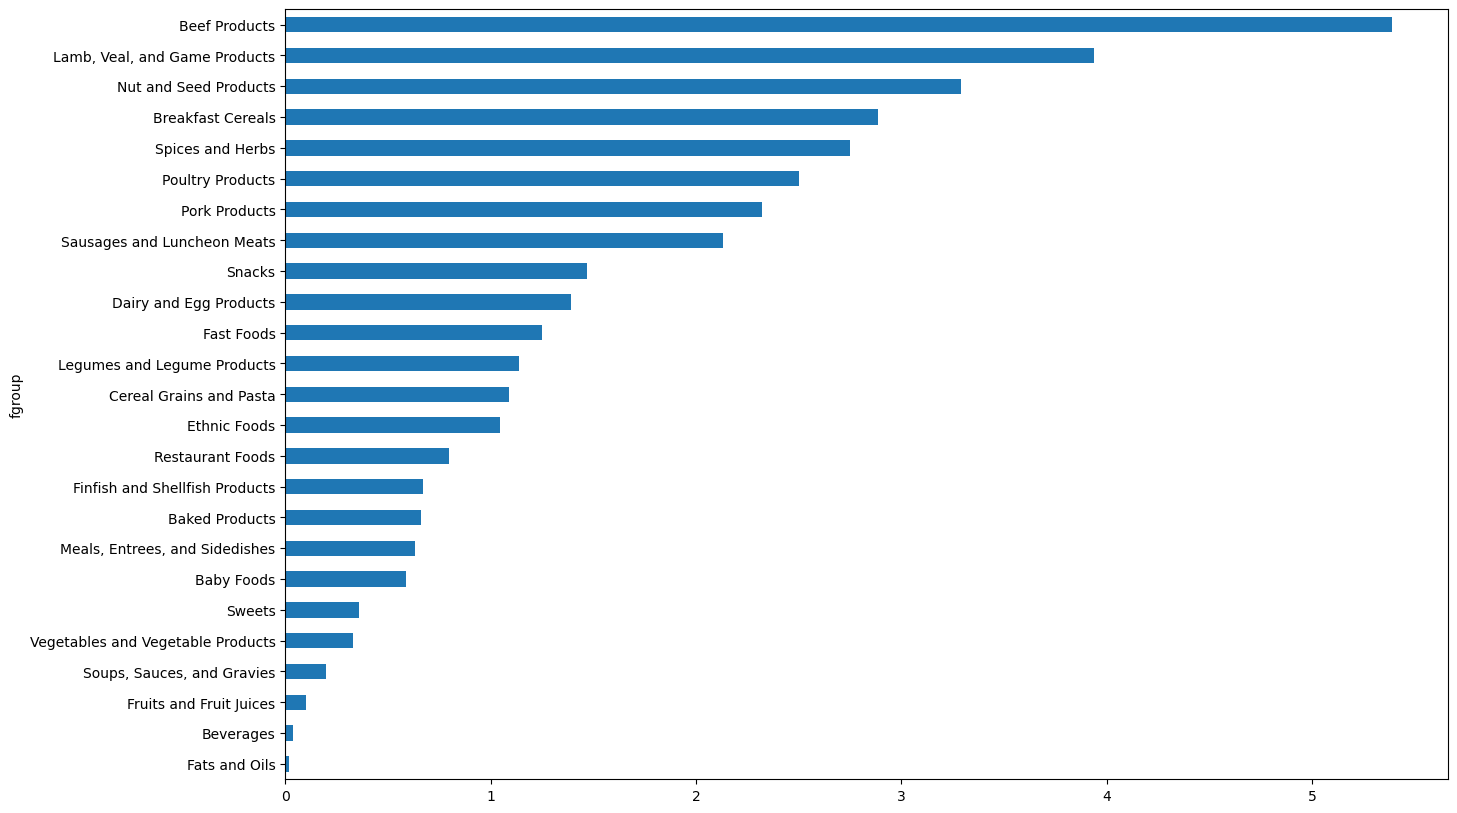

In [179]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh', figsize=(15,10))

We can also investigate which food is richer in each type of nutrient:

In [180]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])
get_maximum = lambda x: x.xs(x.value.idxmax())
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

/tmp/ipykernel_31938/1402640178.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]


In [181]:
max_foods.loc['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 